# manning_MLforFinAnal/part1/data_extraction.ipynb


In [1]:
'''
Extract daily historical stock prices of AT&T and Verizon for the period of 
01/01/2019 - 06/01/2021 via Alpha Vantage API 
and check the data using head() function to see if you properly imported it.

Hint: use StringIO and requests library to access the data using Alpha Vantage API.

Rather than return the data in json format and convert it, 
I used the alphavantage library which returns the data as a Pandas DataFrame.

This video is helpful:
https://www.youtube.com/watch?v=WJ2t_LYb__0

'''

'\nExtract daily historical stock prices of AT&T and Verizon for the period of \n01/01/2019 - 06/01/2021 via Alpha Vantage API \nand check the data using head() function to see if you properly imported it.\n\nHint: use StringIO and requests library to access the data using Alpha Vantage API.\n\nRather than return the data in json format and convert it, \nI used the alphavantage library which returns the data as a Pandas DataFrame.\n\nThis video is helpful:\nhttps://www.youtube.com/watch?v=WJ2t_LYb__0\n\n'

## Retrieve the AlphaVantage API key

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

# The API_KEY is stored in the file named .env, 
#    which is in the same directory as this python program

API_KEY = os.getenv('ALPHAVANTAGE_API_KEY')
#print (API_KEY)  # which we would never do

## Import libraries

In [3]:
#import pandas_datareader as pdr

import matplotlib.pyplot as plt
import pandas as pd

from alpha_vantage.timeseries import TimeSeries
from matplotlib import rcParams

rcParams["figure.figsize"] = 10, 6


## Step 1 -- Download historical data and perform seasonal decomposition

## Retrieve data for AT&T -- symbol 'T' -- and extract 'close' field

In [4]:
app = TimeSeries(key='API_KEY',output_format='pandas', indexing_type='date')
data,meta_data = app.get_daily_adjusted(symbol='T',outputsize='full')

data.rename(columns={'date':'Date','1. open': 'open', '2. high': 'high',
                     '3. low': 'low', '4. close': 'close', 
                     '5. adjusted close':'adjclose',
                     '6. volume': 'volume'},
            inplace=True)
data.sort_values(by='date', ascending=False, inplace=True)

print (meta_data)
print (data.info())
      

{'1. Information': 'Daily Time Series with Splits and Dividend Events', '2. Symbol': 'T', '3. Last Refreshed': '2021-11-09', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5543 entries, 2021-11-09 to 1999-11-01
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  5543 non-null   float64
 1   high                  5543 non-null   float64
 2   low                   5543 non-null   float64
 3   close                 5543 non-null   float64
 4   adjclose              5543 non-null   float64
 5   volume                5543 non-null   float64
 6   7. dividend amount    5543 non-null   float64
 7   8. split coefficient  5543 non-null   float64
dtypes: float64(8)
memory usage: 389.7 KB
None


## Print the head and tail, sort into ascending sequence, plot 'adj close'

In [5]:
print (data.head())
print (data.tail())

             open   high    low  close  adjclose      volume  \
date                                                           
2021-11-09  24.82  24.85  24.58  24.71     24.71  45214810.0   
2021-11-08  25.06  25.13  24.73  24.88     24.88  46194302.0   
2021-11-05  24.85  25.31  24.83  25.10     25.10  44461554.0   
2021-11-04  25.13  25.25  24.54  24.80     24.80  63091148.0   
2021-11-03  25.12  25.33  25.11  25.18     25.18  36375002.0   

            7. dividend amount  8. split coefficient  
date                                                  
2021-11-09                 0.0                   1.0  
2021-11-08                 0.0                   1.0  
2021-11-05                 0.0                   1.0  
2021-11-04                 0.0                   1.0  
2021-11-03                 0.0                   1.0  
             open   high    low  close   adjclose     volume  \
date                                                           
1999-11-05  51.00  51.44  50.50  51.25

In [6]:
data['Date'] = data.index.date

In [7]:
print (data.loc['2019-01-02'])

            open   high   low  close   adjclose      volume  \
date                                                          
2019-01-02  28.5  29.59  28.3  29.54  24.190984  39293953.0   

            7. dividend amount  8. split coefficient        Date  
date                                                              
2019-01-02                 0.0                   1.0  2019-01-02  


In [8]:
data.sort_index(inplace=True)

## Comparing the data in the instructor-supplied data file
##  with the data retrieved, we want the 'close' field.
## This is an unusual choice.

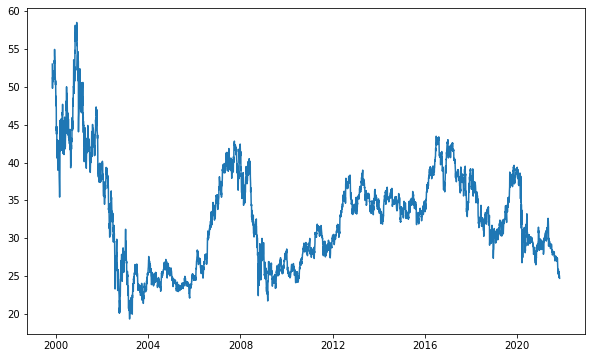

In [9]:
plt.plot(data['close'])

## Select a portion of the data for further analysis, plot it

In [10]:
plot_period = data.loc['2019-01-01':'2021-06-01']

            close
Date             
2019-01-02  29.54
2019-01-03  29.58
2019-01-04  30.34
2019-01-07  30.89
2019-01-08  31.28


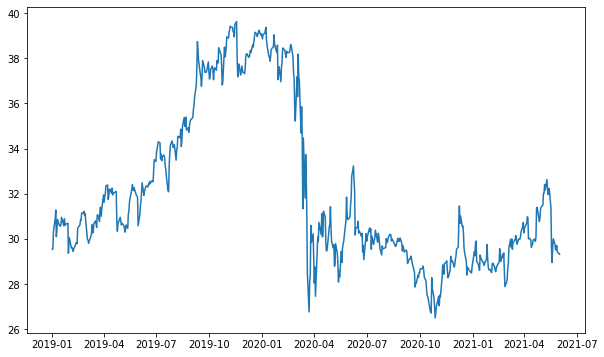

In [11]:
sample_data = data.drop(columns=['open','high','low','adjclose',
                         'volume','7. dividend amount',
                          '8. split coefficient'])
sample_data = sample_data.loc['2019-01-01':'2021-06-01']
sample_data = sample_data.set_index('Date')

print (sample_data.head())
plt.plot(sample_data)

In [12]:
print (sample_data.describe())
print (sample_data.dtypes)

            close
count  608.000000
mean    32.051924
std      3.494590
min     26.500000
25%     29.577500
50%     30.670000
75%     34.197500
max     39.630000
close    float64
dtype: object


###  Observation

There is no appreciable trend from the beginning of the period to the end.
The steep drop in price mid-chart will obsecure any linear trend or seasonality analysis.

## Decompose the time series
### First using the additive model
y(t) = Level + Trend + Seasonality + Noise

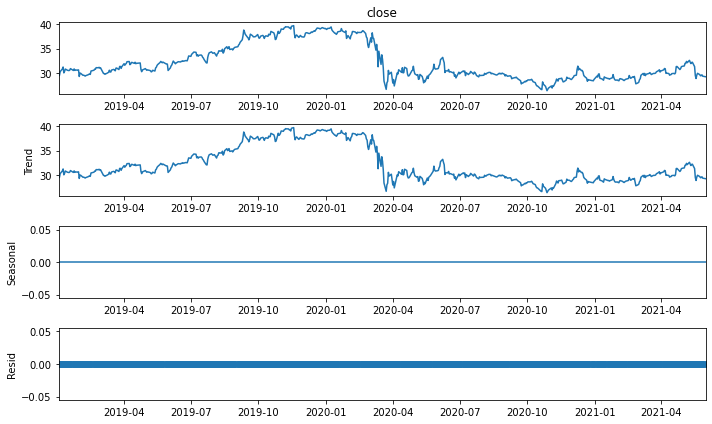

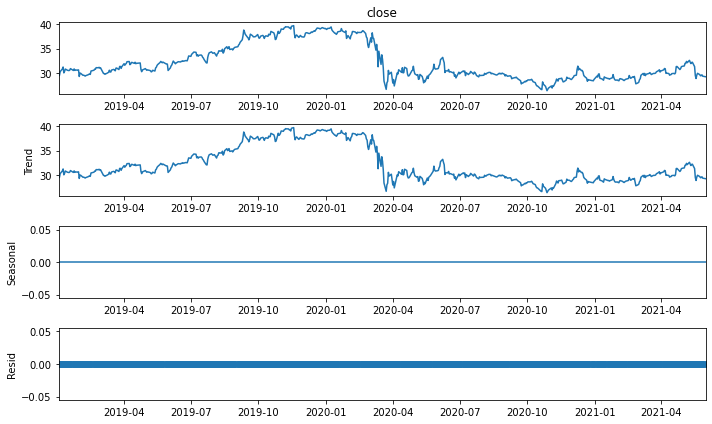

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

series = sample_data['close']
series.dropna(inplace=True)

result = seasonal_decompose(series,model='additive',period=1)

#print(result.trend)
#print(result.seasonal)
#print(result.resid)
#print(result.observed)

result.plot()


### Next using the multiplicative model
y(t) = Level * Trend * Seasonality * Noise

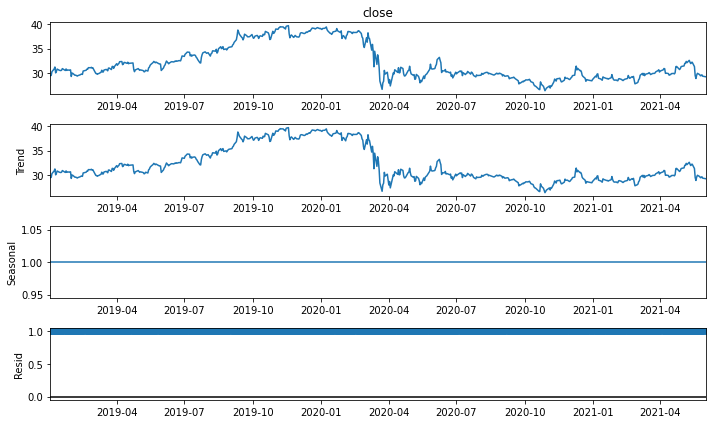

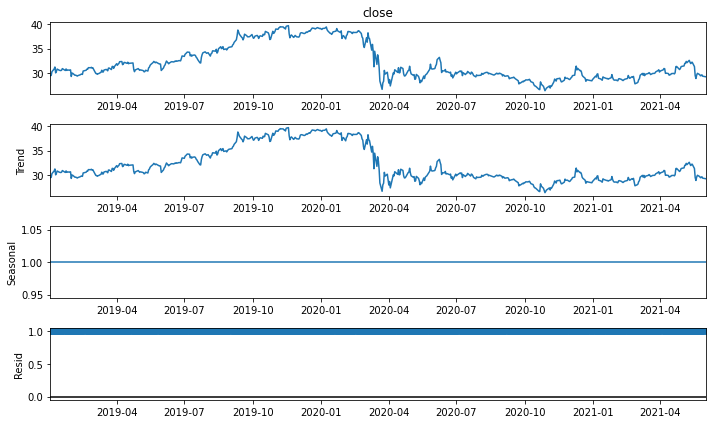

In [14]:
series = sample_data['close']
series.dropna(inplace=True)

result = seasonal_decompose(series,model='multiplicative',period=1)

#print(result.trend)
#print(result.seasonal)
#print(result.resid)
#print(result.observed)

result.plot()


## Step 2 -- Analyze autocorrelation

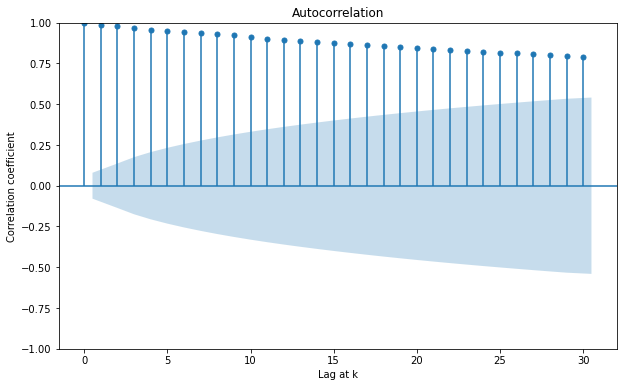

In [15]:
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(series, lags=30)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

/home/howard/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


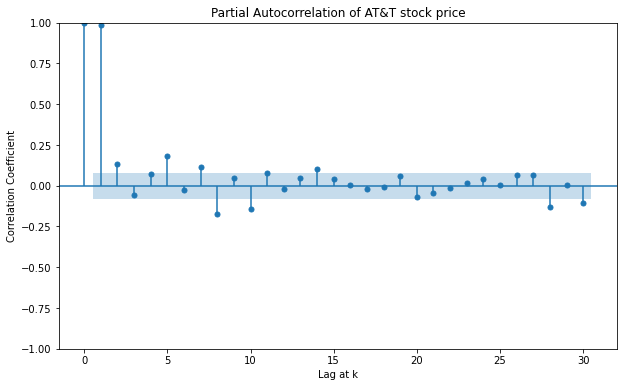

In [16]:
fig = tsaplots.plot_pacf(series, lags=30)

plt.title("Partial Autocorrelation of AT&T stock price")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

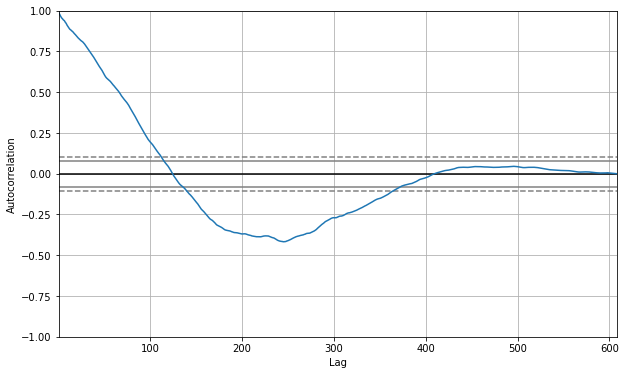

In [17]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

## Step 3 -- Investigate stationarity using adf test

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
#  recall -- series contains the closing price of AT&T stock
result = adfuller(series, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -1.363302121751866
n_lags: 0.5997376884583795
p-value: 0.5997376884583795
Critial Values:
   1%, -3.441406876071572
Critial Values:
   5%, -2.866418015869717
Critial Values:
   10%, -2.5693678601956718


###  Observation
The ADF statistic is -1.36
which is higher than the 5% critical value of -2.87
suggesting the data is Not stationary.

This is in agreement with the appearance of the price plot above,
which shows considerable variation in both mean and variance
over the period analyzed.

# -----------------  Repeat everything for Verizon -- VZ ------------------

## Why duplicate an experiment that shows that analysis of stock price
## using seasonal decomposition and autocorrelation are not useful????

## Step 1 -- Download historical data and perform seasonal decomposition

## Retrieve data for Verizon -- symbol 'VZ' -- and extract 'close' field

In [20]:
app = TimeSeries(key='API_KEY',output_format='pandas', indexing_type='date')
data,meta_data = app.get_daily_adjusted(symbol='VZ',outputsize='full')

data.rename(columns={'date':'Date','1. open': 'open', '2. high': 'high',
                     '3. low': 'low', '4. close': 'close', 
                     '5. adjusted close':'adjclose',
                     '6. volume': 'volume'},
            inplace=True)
data.sort_values(by='date', ascending=False, inplace=True)

print (meta_data)
print (data.info())
      

{'1. Information': 'Daily Time Series with Splits and Dividend Events', '2. Symbol': 'VZ', '3. Last Refreshed': '2021-11-09', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5543 entries, 2021-11-09 to 1999-11-01
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  5543 non-null   float64
 1   high                  5543 non-null   float64
 2   low                   5543 non-null   float64
 3   close                 5543 non-null   float64
 4   adjclose              5543 non-null   float64
 5   volume                5543 non-null   float64
 6   7. dividend amount    5543 non-null   float64
 7   8. split coefficient  5543 non-null   float64
dtypes: float64(8)
memory usage: 389.7 KB
None


In [21]:
print (data.head())
print (data.tail())

             open    high    low  close  adjclose      volume  \
date                                                            
2021-11-09  52.30  52.370  51.99  52.24     52.24  15632396.0   
2021-11-08  52.30  52.415  51.91  52.33     52.33  15985225.0   
2021-11-05  52.02  52.800  52.02  52.24     52.24  17442839.0   
2021-11-04  52.91  52.910  51.20  51.85     51.85  30807502.0   
2021-11-03  52.59  53.070  52.52  52.94     52.94  12240049.0   

            7. dividend amount  8. split coefficient  
date                                                  
2021-11-09                 0.0                   1.0  
2021-11-08                 0.0                   1.0  
2021-11-05                 0.0                   1.0  
2021-11-04                 0.0                   1.0  
2021-11-03                 0.0                   1.0  
             open   high    low  close   adjclose     volume  \
date                                                           
1999-11-05  62.81  63.50  62.31

In [22]:
data['Date'] = data.index.date

In [23]:
print (data.loc['2019-01-02'])

             open   high    low  close   adjclose      volume  \
date                                                            
2019-01-02  56.16  56.16  55.28  56.02  49.232075  13969691.0   

            7. dividend amount  8. split coefficient        Date  
date                                                              
2019-01-02                 0.0                   1.0  2019-01-02  


            close
Date             
2021-06-01  56.38
2021-05-28  56.49
2021-05-27  56.29
2021-05-26  56.36
2021-05-25  56.48


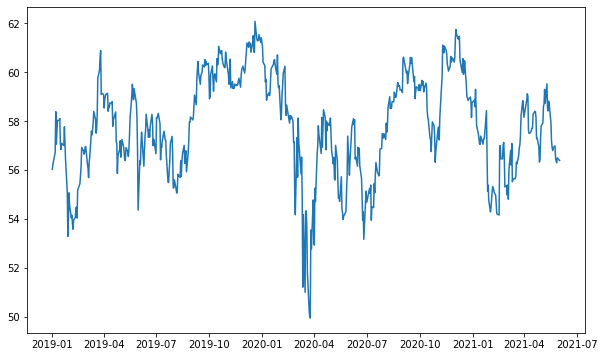

In [24]:
sample_data = data.drop(columns=['open','high','low','adjclose',
                         'volume','7. dividend amount',
                          '8. split coefficient'])
sample_data = sample_data.loc['2019-01-01':'2021-06-01']
sample_data = sample_data.set_index('Date')

print (sample_data.head())
plt.plot(sample_data)

###  Observation

Again, there is no appreciable trend from the beginning of the period to the end.
The steep drop in price mid-chart will obsecure any linear trend or seasonality analysis.

## Decompose the time series
### First using the additive model
y(t) = Level + Trend + Seasonality + Noise

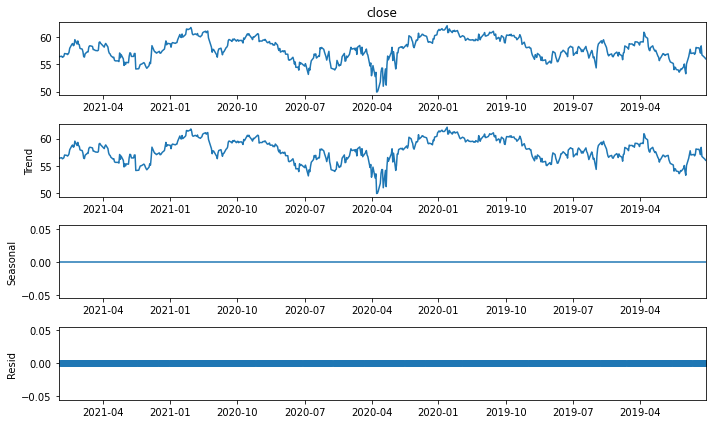

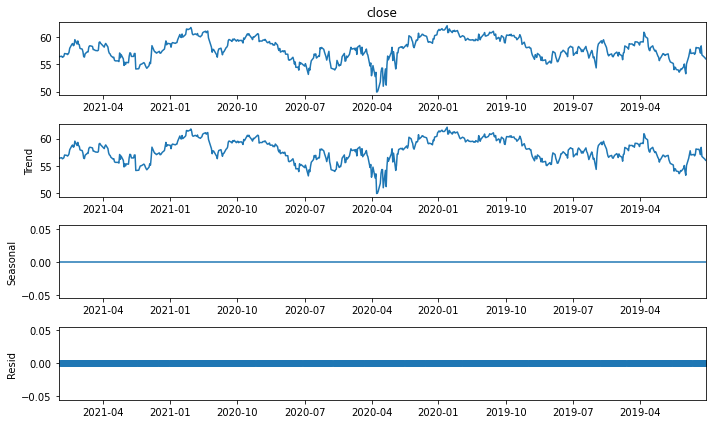

In [25]:
series = sample_data['close']
series.dropna(inplace=True)

result = seasonal_decompose(series,model='additive',period=1)

#print(result.trend)
#print(result.seasonal)
#print(result.resid)
#print(result.observed)

result.plot()


### Next using the multiplicative model
y(t) = Level * Trend * Seasonality * Noise

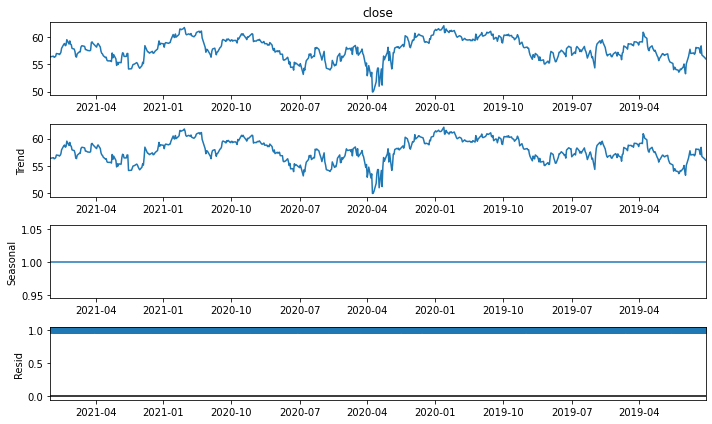

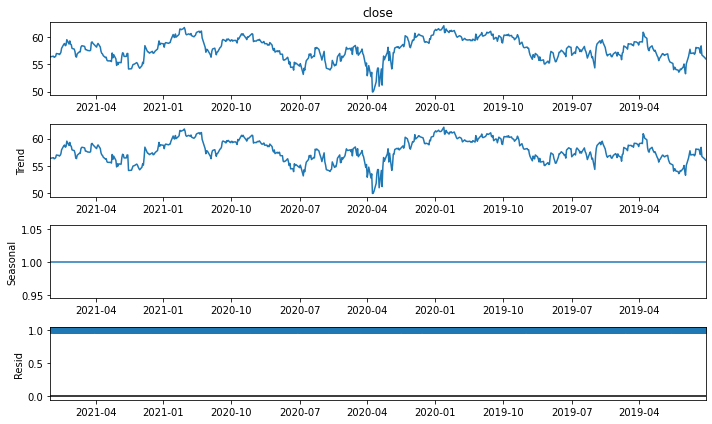

In [26]:
series = sample_data['close']
series.dropna(inplace=True)

result = seasonal_decompose(series,model='multiplicative',period=1)

#print(result.trend)
#print(result.seasonal)
#print(result.resid)
#print(result.observed)

result.plot()

## The decomposition is similar to that of AT&T.  
## Further analysis using the same tools is not valuable.

In [28]:
print ('all done')

all done
